In [2]:
import torch 
from torch import nn
import matplotlib.pyplot as plt

In [1]:
import torch 

In [3]:
torch.manual_seed(0)

In [4]:
def generate_dataset(N = 2000, d=2):
    N_1 = int(N/2)
    N_2 = N-N_1 

    class_1 = torch.randn((N_1, d))

    class_2 = torch.randn((N_2, d))
    class_2 /= torch.linalg.norm(class_2, dim=1).unsqueeze(-1)
    class_2 = class_2*4 +  torch.randn((N_2, d))*0.9

    return torch.vstack([class_1, class_2]), torch.hstack([torch.zeros(N_1), torch.ones(N_2)])

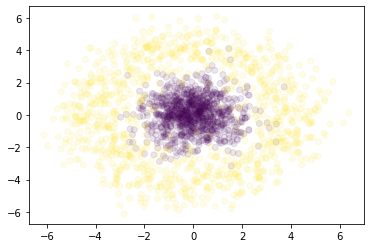

In [5]:
X, y = generate_dataset()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.1)

In [6]:
def batch_jacobian(func, x, create_graph=False):
  # x in shape (Batch, Length)
  def _func_sum(x):
    return func(x).sum(dim=0)
  return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

def bernoulli_loss(theta_pred, y):
    return y*torch.log(theta_pred + 1e-10) + (1-y)*torch.log(1-theta_pred  + 1e-10)

def fisher_information(theta_pred):
    return 1/(theta_pred*(1-theta_pred))

In [7]:
net = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50,50), nn.ReLU(), nn.Linear(50,1), nn.Sigmoid())

In [8]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
for i in range(10000):
    optim.zero_grad()
    y_pred = net(X)
    loss = -bernoulli_loss(y_pred.squeeze(), y).sum()
    if (i % 1000) == 0:
        print(loss.detach())
    loss.backward()
    optim.step()

tensor(1413.5287)
tensor(235.1966)
tensor(224.8420)
tensor(213.4803)
tensor(197.5004)
tensor(185.6262)
tensor(176.7454)
tensor(170.1068)
tensor(163.9442)
tensor(158.8110)


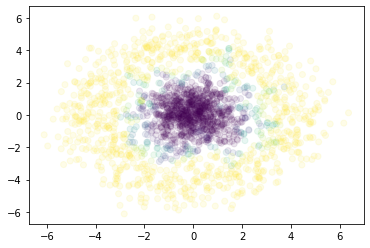

In [8]:
plt.scatter(X[:,0], X[:,1], c=net(X).detach(), alpha=0.1)

c:\ProgramData\Miniconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


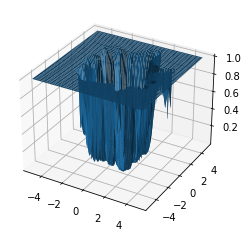

In [9]:
%matplotlib inline

x = torch.linspace(-5,5, 1000)
yy = torch.linspace(-5,5, 1000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(1000, 1000))

In [10]:
net = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50,50), nn.ReLU(), nn.Linear(50,1), nn.Sigmoid())

In [11]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
lam = 0.5
for i in range(10000):
    optim.zero_grad()
    y_pred = net(X)
    Js = batch_jacobian(net, X, create_graph=True)
    loss = -bernoulli_loss(y_pred.squeeze(), y).sum() + lam*torch.sum(fisher_information(y_pred).squeeze()*(Js@torch.transpose(Js, -2,-1)).squeeze())
    if (i % 1000) == 0:
        print(loss.detach())
    loss.backward()
    optim.step()

tensor(1368.8152)
tensor(614.4655)
tensor(618.8633)
tensor(619.8508)
tensor(620.0129)
tensor(620.0067)
tensor(619.9276)
tensor(619.8515)
tensor(619.9004)
tensor(619.9594)


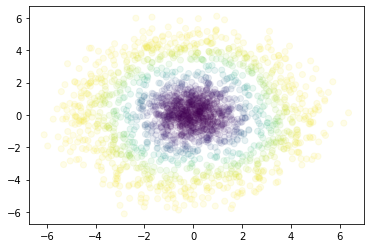

In [12]:
plt.scatter(X[:,0], X[:,1], c=net(X).detach(), alpha=0.1)

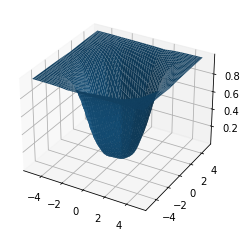

In [13]:
%matplotlib inline

x = torch.linspace(-5,5, 1000)
yy = torch.linspace(-5,5, 1000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(1000, 1000))

In [14]:
def generate_dataset(N = 3000, d=2):
    N_1 = int(N/3)
    N_2 = int(N/3)
    N_3 = N-N_1 - N_2

    class_1 = torch.randn((N_1, d))

    class_2 = torch.randn((N_2, d))
    class_2 /= torch.linalg.norm(class_2, dim=1).unsqueeze(-1)
    class_2 = class_2*4 +  torch.randn((N_2, d))*0.9

    class_3 = torch.randn((N_3, d))
    class_3 /= torch.linalg.norm(class_3, dim=1).unsqueeze(-1)
    class_3 = class_3*5.5 +  torch.randn((N_3, d))*0.1

    return torch.vstack([class_1, class_2, class_3]), torch.hstack([torch.zeros(N_1), torch.ones(N_2), 2*torch.ones(N_3)])

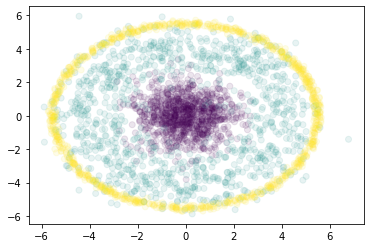

In [15]:
X, y = generate_dataset()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.1)

In [36]:
def categorical_loss(theta_pred, y):
    return (y==0)*torch.log(theta_pred[:,0] + 1e-20) + (y==1)*torch.log(theta_pred[:,1]  + 1e-20) + (y==2)*torch.log(theta_pred[:,2]  + 1e-20)

def fisher_information(theta_pred):
    return torch.diag_embed(1/(theta_pred + 1e-20))

In [37]:
net = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50,50), nn.ReLU(), nn.Linear(50,3), nn.Softmax())

In [38]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
for i in range(10000):
    optim.zero_grad()
    y_pred = net(X)
    loss = -categorical_loss(y_pred.squeeze(), y).sum()
    if (i % 1000) == 0:
        print(loss.detach())
    loss.backward()
    optim.step()

tensor(2480.8606)
tensor(235.1821)
tensor(221.9216)
tensor(205.4576)
tensor(195.5524)
tensor(185.4545)
tensor(176.5737)
tensor(170.1384)
tensor(165.3475)
tensor(160.9489)


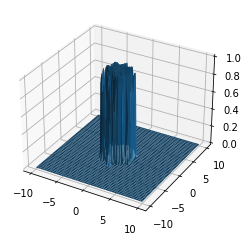

In [19]:
%matplotlib inline

x = torch.linspace(-10,10, 2000)
yy = torch.linspace(-10,10, 2000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))[:, 0]

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(2000, 2000))

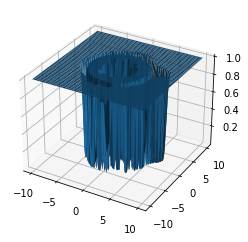

In [20]:
%matplotlib inline

x = torch.linspace(-10,10, 2000)
yy = torch.linspace(-10,10, 2000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))[:, 1]

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(2000, 2000))

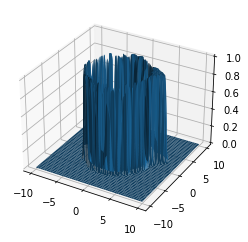

In [21]:
%matplotlib inline

x = torch.linspace(-10,10, 2000)
yy = torch.linspace(-10,10, 2000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))[:, 2]

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(2000, 2000))

(-10.0, 10.0, -10.0, 10.0)

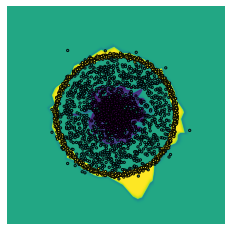

In [28]:
x = torch.linspace(-10,10, 2500)
yy = torch.linspace(-10,10, 2500)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))
del XX
del YY
colors = torch.argmax(cs, axis=1) + torch.max(cs, axis=1).values.detach() -1
plt.imshow(colors.reshape(2500, 2500), extent=[-10, 10, -10, 10])
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.9, edgecolors="black", s=5)
plt.axis("off")

In [23]:
# Some adversarial exampels obtained by similar technique

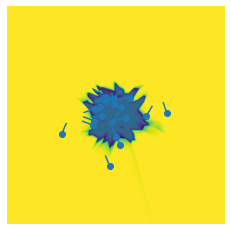

In [39]:
x = torch.linspace(-10,10, 2500)
yy = torch.linspace(-10,10, 2500)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))
del XX
del YY
colors = torch.argmax(cs, axis=1) + torch.max(cs, axis=1).values.detach() -1
plt.imshow(colors.reshape(2500, 2500), extent=[-10, 10, -10, 10])
plt.axis("off")

x = torch.randn(20,2)*2

J = batch_jacobian(net, x)

matrix = torch.transpose(J,-2,-1)@fisher_information(net(x))@J
adv_direction = torch.linalg.eigh(matrix).eigenvectors[:,-1,:].detach()


plt.scatter(x[:,0], x[:,1])
for i in range(len(x)):
    plt.plot([x[i,0], x[i,0]+adv_direction[i, 0]], [x[i,1], x[i,1]+adv_direction[i, 1]], color="C0")

In [97]:
vs1, vs2 = torch.autograd.functional.jvp(net, x, torch.tensor([[1., 0.]]).repeat(20,1))

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [148]:
unit_vectors = torch.eye(2)
trace = 0
for e_i in unit_vectors:
    vjp =  torch.autograd.functional.jvp(net, x, e_i.repeat(20,1))[1]
    trace += torch.einsum("bi, bij, bj -> b", vjp, F, vjp)

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [160]:
mc_samples = 10000
unit_vectors = torch.randn(mc_samples,2)
trace = 0
for e_i in unit_vectors:
    vjp =  torch.autograd.functional.jvp(net, x, e_i.repeat(20,1))[1]
    trace += torch.einsum("bi, bij, bj -> b", vjp, F, vjp)/mc_samples

In [161]:
trace.round()

tensor([11., 13.,  1., 49.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         7.,  2.,  0.,  0.,  0.,  0.], grad_fn=<RoundBackward0>)

In [162]:
torch.diagonal(matrix, dim1=1, dim2=2).sum(1).round()

tensor([11., 13.,  1., 49.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         7.,  2.,  0.,  0.,  0.,  0.], grad_fn=<RoundBackward0>)

In [131]:
vs1, vs2 = torch.autograd.functional.jvp(net, x.repeat(1,2).reshape(-1,2), torch.eye(2).repeat(20,1))

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [136]:
vs2

tensor([[-6.6026e-01,  6.6026e-01,  1.5687e-09],
        [-2.3013e-01,  2.3013e-01,  1.4186e-10],
        [-5.4837e-01,  5.4837e-01, -1.4516e-11],
        [-9.1400e-01,  9.1400e-01, -5.7813e-12],
        [-7.1212e-02,  7.1212e-02, -3.0511e-12],
        [ 1.6638e-01, -1.6638e-01,  4.8917e-11],
        [-2.6564e+00,  2.6564e+00,  1.1735e-09],
        [-3.1262e-01,  3.1262e-01, -1.8295e-09],
        [-3.3352e-04,  3.3367e-04, -1.9740e-19],
        [ 9.6562e-04, -9.6563e-04, -1.6399e-20],
        [-1.2921e-02,  1.2918e-02,  1.4973e-06],
        [-2.7489e-03,  2.7482e-03,  4.7323e-07],
        [ 4.9190e-02, -4.9191e-02, -3.9582e-10],
        [ 2.1476e-02, -2.1476e-02, -3.9342e-10],
        [ 2.0893e-03, -2.0898e-03, -2.0394e-10],
        [ 7.3380e-04, -7.3403e-04, -1.7510e-10],
        [ 1.4305e-05, -1.4061e-05, -3.0240e-08],
        [ 2.1934e-05, -2.1715e-05, -5.5261e-08],
        [ 4.1442e-18,  0.0000e+00,  4.1826e-28],
        [ 9.4367e-18,  0.0000e+00,  3.0104e-28],
        [-1.2802e-02

In [96]:
J

tensor([[[-6.6026e-01, -2.3013e-01],
         [ 6.6026e-01,  2.3013e-01],
         [ 1.5687e-09,  1.4186e-10]],

        [[-5.4837e-01, -9.1400e-01],
         [ 5.4837e-01,  9.1400e-01],
         [-1.4516e-11, -5.7813e-12]],

        [[-7.1212e-02,  1.6638e-01],
         [ 7.1212e-02, -1.6638e-01],
         [-3.0511e-12,  4.8917e-11]],

        [[-2.6564e+00, -3.1262e-01],
         [ 2.6564e+00,  3.1262e-01],
         [ 1.1735e-09, -1.8295e-09]],

        [[-3.3352e-04,  9.6562e-04],
         [ 3.3356e-04, -9.6564e-04],
         [-1.9740e-19, -1.6399e-20]],

        [[-1.2920e-02, -2.7490e-03],
         [ 1.2918e-02,  2.7482e-03],
         [ 1.4973e-06,  4.7323e-07]],

        [[ 4.9190e-02,  2.1476e-02],
         [-4.9191e-02, -2.1476e-02],
         [-3.9582e-10, -3.9342e-10]],

        [[ 2.0894e-03,  7.3383e-04],
         [-2.0898e-03, -7.3403e-04],
         [-2.0394e-10, -1.7510e-10]],

        [[ 1.4425e-05,  2.2345e-05],
         [-1.4061e-05, -2.1715e-05],
         [-3.0240e-08,

In [137]:
F = fisher_information(net(x))

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [144]:
diags = torch.einsum("bi, bij, bj -> b", vs2, F.repeat(1, 2, 1).reshape(-1,3,3), vs2)

In [145]:
diags[::2] + diags[1::2]

tensor([1.1113e+01, 1.2760e+01, 1.1578e+00, 4.8859e+01, 3.0806e-03, 4.8235e-01,
        1.5444e+00, 6.3887e-02, 7.4287e-04, 1.8863e-16, 6.6467e-01, 1.4261e-15,
        1.4266e+00, 1.1885e+00, 6.7680e+00, 1.5137e+00, 3.3619e-01, 5.4403e-04,
        3.6362e-08, 2.8963e-01], grad_fn=<AddBackward0>)

In [155]:
torch.diagonal(matrix, dim1=1, dim2=2).sum(1).round()

tensor([11., 13.,  1., 49.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         7.,  2.,  0.,  0.,  0.,  0.], grad_fn=<RoundBackward0>)

In [75]:
torch.trace(matrix[0])

tensor(11.1125, grad_fn=<TraceBackward0>)

In [125]:
adversarial_direction = torch.linalg.eig(matrix)

In [126]:
adversarial_direction

torch.return_types.linalg_eig(
eigenvalues=tensor([[0.0000e+00+0.j, 2.9489e-07+0.j, 0.0000e+00+0.j]],
       grad_fn=<LinalgEigBackward0>),
eigenvectors=tensor([[[ 9.1877e-01+0.j, -9.5069e-10+0.j,  0.0000e+00+0.j],
         [ 3.9479e-01+0.j,  1.0000e+00+0.j,  0.0000e+00+0.j],
         [ 0.0000e+00+0.j,  0.0000e+00+0.j,  1.0000e+00+0.j]]],
       grad_fn=<LinalgEigBackward0>))

In [92]:
net = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50,50), nn.ReLU(), nn.Linear(50,3), nn.Softmax())

In [93]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
lam = 0.1
for i in range(10000):
    optim.zero_grad()
    y_pred = net(X)
    Js = batch_jacobian(net, X, create_graph=True)
    loss = -categorical_loss(y_pred.squeeze(), y).sum() + lam*torch.diagonal(fisher_information(net(X))@(Js@torch.transpose(Js, -2, -1)), dim1=-2,dim2=-1).sum(-1).sum()
    if (i % 1000) == 0:
        print(loss.detach())
    loss.backward()
    optim.step()

tensor(3234.8523)
tensor(984.7960)
tensor(954.0151)
tensor(937.1523)
tensor(932.3308)
tensor(930.8562)
tensor(931.3350)
tensor(930.1697)
tensor(931.1888)
tensor(933.1868)


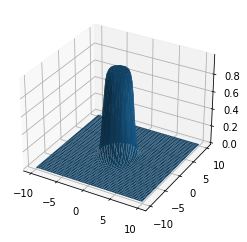

In [98]:
%matplotlib inline

x = torch.linspace(-10,10, 2000)
yy = torch.linspace(-10,10, 2000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))[:, 0]

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(2000, 2000))

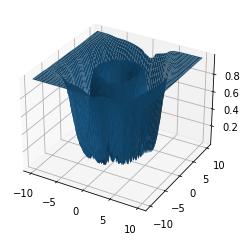

In [99]:
%matplotlib inline

x = torch.linspace(-10,10, 2000)
yy = torch.linspace(-10,10, 2000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))[:, 1]

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(2000, 2000))

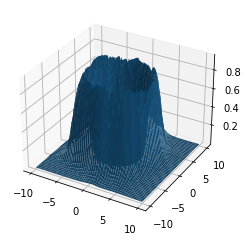

In [100]:
%matplotlib inline

x = torch.linspace(-10,10, 2000)
yy = torch.linspace(-10,10, 2000)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))[:, 2]

ax = plt.axes(projection='3d')
ax.plot_surface(XX,YY, cs.detach().reshape(2000, 2000))

(-10.0, 10.0, -10.0, 10.0)

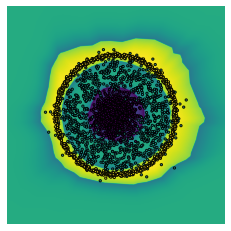

In [111]:
x = torch.linspace(-10,10, 2500)
yy = torch.linspace(-10,10, 2500)
XX, YY = torch.meshgrid(x,yy)

cs = net(torch.hstack([XX.reshape(-1,1), YY.reshape(-1,1)]))
del XX
del YY
colors = torch.argmax(cs, axis=1) + torch.max(cs, axis=1).values.detach() -1
plt.imshow(colors.reshape(2500, 2500), extent=[-10, 10, -10, 10])
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.9, edgecolors="black", s=5)
plt.axis("off")

In [107]:
# Mnist example

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1,  ..., 1, 1, 1]))

In [51]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import numpy as np 
from torchvision.utils import make_grid as make_image_grid

In [10]:
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

In [531]:
net = nn.Sequential(nn.Linear(784, 512), nn.ReLU(), nn.Linear(512,256), nn.ReLU(), nn.Linear(256,10), nn.Softmax())

In [795]:
def categorical_loss(theta_pred, y):
    return sum([(y==i)*torch.log(theta_pred[:,i]  + 1e-20).flatten() for i in range(10)])

def accuracy(dataloader):
    acc = 0
    N = 0
    for X,y in dataloader:
        pred = net(X.reshape(-1, 784)).argmax(axis=1)
        acc += torch.mean((pred == y).float())
        N+=1
    return acc/N

In [796]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
for i in range(10):
    full_loss = 0
    for X,y in trainloader:
        optim.zero_grad()
        y_pred = net(X.reshape(-1, 784))
        loss = -categorical_loss(y_pred.squeeze(), y).sum()
        # loss.backward()
        optim.step()
        full_loss += loss.detach()
    print(full_loss)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [793]:
accuracy(testloader)

tensor(0.0961)

In [791]:
num = 7

with torch.no_grad():
    x, y = testloader.dataset[num][0], testloader.dataset[num][1]

    J = batch_jacobian(net, x.reshape(-1,784))

    matrix = torch.transpose(J,-2,-1)@fisher_information(net(x.reshape(-1,784)))@J
    adv_direction = torch.linalg.eigh(matrix.squeeze())

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [792]:
adv_direction.eigenvalues[-1]

tensor(0.)

In [680]:
adv_direction.eigenvectors[:, -1].max()

tensor(0.1550)

In [782]:
# is there a better?

import geotorch

def kl_div_cat(theta_x, theta_x_dist):
    cat1 = torch.distributions.Categorical(theta_x) 
    cat2 = torch.distributions.Categorical(theta_x_dist) 
    return torch.distributions.kl_divergence(cat1, cat2)

In [783]:
spherical_samples = geotorch.Sphere((1000,784)).sample()
with torch.no_grad():
    theta_x = net(x.reshape(-1,784))
    thetas_pert = net(x.reshape(-1, 784) + spherical_samples)

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [683]:
kl_divs = kl_div_cat(theta_x, thetas_pert)
kl_divs.mean()

tensor(0.1035)

In [685]:
kl_div_adv = kl_div_cat(theta_x, net(x.reshape(-1,784) + adv_direction.eigenvectors[:,-1].reshape(-1, 784)).detach())
kl_div_adv

tensor([15.2828])

In [720]:
delta = torch.randn((1000, 784), requires_grad=True)
opt = torch.optim.Adam([delta])

for i in range(100):
    opt.zero_grad()
    thetas_pert2 = net(x.reshape(-1, 784) + delta)
    loss = - kl_div_cat(theta_x.detach(), thetas_pert2).sum()
    loss.backward(retain_graph=True)
    opt.step()
    with torch.no_grad():
        delta = delta / torch.linalg.norm(delta, dim=-1).unsqueeze(-1)
        print(loss)

tensor(-inf, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, grad_fn=<NegBackward0>)
tensor(-86.8368, gra

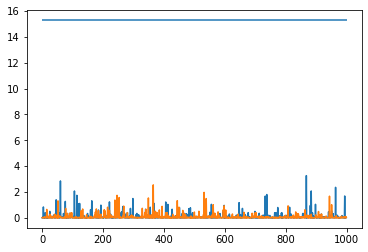

In [723]:
plt.plot(kl_divs.detach())
plt.plot(kl_divs_ad.detach())
#plt.hlines(0.5*adv_direction.eigenvalues[-1].detach(), 0, 1000)
plt.hlines(kl_div_adv.detach(), 0, 1000)

In [790]:
adv_direction

torch.return_types.linalg_eigh(
eigenvalues=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

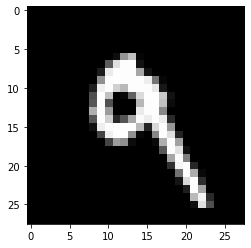

In [623]:
plt.imshow(np.transpose(make_image_grid(x).numpy(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


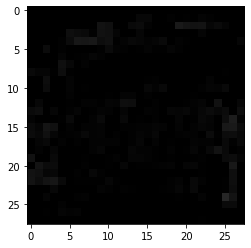

In [624]:
plt.imshow(np.transpose(make_image_grid(adv_direction.eigenvectors[:,-1].reshape(1, 28,28)).numpy(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


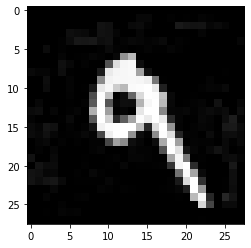

In [625]:
plt.imshow(np.transpose(make_image_grid(x).numpy() + make_image_grid(adv_direction.eigenvectors[:,-1].reshape(1, 28,28)).numpy(), (1,2,0)))

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


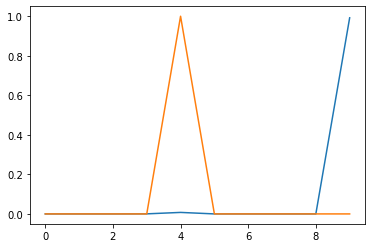

In [626]:
plt.plot(range(10),net(x.reshape(-1,784)).detach().flatten())

plt.plot(range(10),net(x.reshape(-1,784) + adv_direction.eigenvectors[:,-1].reshape(-1, 784)).detach().flatten())

In [141]:
adv_direction.eigenvectors.shape

torch.Size([784, 784])